In [25]:
import numpy as np
import matplotlib.pyplot as plt

from threading import Thread
from tqdm import tqdm
from io import StringIO
import time
from struct import unpack
from copy import copy, deepcopy
import pyvisa
import visa
import time
import logic.pulsed.pulse_objects as po
import TimeTagger as tt
from IPython.display import display

In [28]:
def optimize():
    confocal.refocus_clicked()
    time.sleep(1)
    while optimizerlogic.module_state()=='locked':
        time.sleep(1)
    return 

In [3]:
class AWG520(object):
    """Controller for the Tektronix AWG520 device.
    
    SCPI commands are issued via gpib.
    See device manual for command documentation.
    File management is done via FTP.
    
    """
    
    def __init__(self, gpib='GPIB0::4::INSTR',
                       ftp='129.69.46.81',
                       socket=('129.69.46.81', 4000)):
        self.socket_addr = socket
        # set ftp parameters
        self.ftp_addr = ftp
        self.ftp_user = '\r'
        self.ftp_pw = '\r'
        self.ftp_cwd = '/main'
        # self.ftp_manager = FTPManager(self)
        self.todo = -1
        self.done = -1
        # setup gpib connection
        self.gpib_addr = gpib
        self.rm = pyvisa.ResourceManager()
        self.gpib = self.rm.open_resource(self.gpib_addr)
        #self.gpib.read_termination = "\n"
        self.gpib.timeout = 1000000
        self.gpib_lock = threading.Lock()
        self.upload_timeout = 1000000
        self.abort = False
        
    def connect_ftp(self):
        connection_trial_number = 0
        while connection_trial_number < 2:
            try:
                self.ftp = FTP(self.ftp_addr, timeout=3.0)
                connection_trial_number = 5
            except:
                print("ftp error:", sys.exc_info()[0])
                print("FTP connection did not work, retry")
                connection_trial_number += 1
        self.ftp.set_pasv(False)
        self.ftp.login('a', 'a')
        self.ftp.cwd(self.ftp_cwd)
        
    def disconnect_ftp(self):
        self.ftp.quit()

    def __del__(self):
        self.gpib.close()

    def reconnect_gpib(self):
        self.gpib.close()
        self.gpib =self.rm.open_resource(self.gpib_addr)
        self.gpib.timeout = 240000
    
    # ____________
    # File Management

    def upload(self, files):
        if not isinstance(files, (list, tuple)):
            files = [files]
        if isinstance(files[0], Waveform):
            # print "upload using ftp"
            # self.upload_ftp(files)
            print("Uploading with the GPIB . . .")
            self.upload_gpib(files)  # ftp should be better, but crashed just recently
        elif isinstance(files[0], Sequence):
            # print "upload using gpib"
            self.upload_gpib(files)
        else:
            print("unknown filetype to upload")
            raise IOError

    def upload_ftp(self, files):
        # allow single files
        uploaded = False
        count = 0
        while not uploaded and count < 10:
            try:
                self.connect_ftp()
                uploaded = True
            except:
                print("ftp error:", sys.exc_info()[0])
                uploaded = False
                count += 1
                break
            if not isinstance(files, (list, tuple)):
                files = [files]

            # opens up new ftp connections in separate threads
            self.todo = len(files)
            self.done = 0
            for i, fil in enumerate(files):
                if self.abort:
                    break
                print('\rUploading '+fil.name + ' to AWG ('+str(i+1)+' of '+str(len(files))+')')
                try:
                    self.ftp.storbinary('STOR ' + fil.name, fil)
                except:
                    print("ftp error:", sys.exc_info()[0])
                    return
            print("")
            self.disconnect_ftp()
        
    def delete(self, files):
        self.connect_ftp()
        if not isinstance(files, (list, tuple)):
            files = [files]
    
        # opens up new ftp connections in separate threads
        self.todo = len(files)
        self.done = 0
        for i, fil in enumerate(files):
            print('Deleting ' + fil + ' from AWG (' + str(i) + ' of ' + str(len(files)) + ')')
            self.ftp.voidcmd('DELE ' + fil)
        self.disconnect_ftp()

    def upload_gpib(self, files):
        if not isinstance(files, (list, tuple)):
            files = [files]
    
        self.todo = len(files)
        self.done = 0
        for i, fil in enumerate(files):
            if self.abort:
                break
            print('\rUploading '+fil.name + ' to AWG ('+str(i+1)+' of '+str(len(files))+')')
            _timer = 0.
            # print "gpib upload process"
            while not fil.state == 'ready':
                time.sleep(0.1)
                _timer += 0.1
                print(r"\r not ready, _timer is " + str(_timer))
                if _timer >= self.upload_timeout:
                    print('Timed out.')
                    break
            n_bytes = len(fil.header)+len(fil.data.tobytes())+len(fil.trailer)
            n_digits = len(str(n_bytes))
            header = f'MMEM:DATA "{fil.name}",'
            self.header = header + f"#{n_digits:d}{n_bytes:d}"
            self.debug_data = fil.data
            awg.tell_raw(self.header.encode("ascii")+fil.header.encode("ascii")+fil.data.tobytes()+fil.trailer.encode("ascii"))
            
            time.sleep(.1)
        print("")
            
    def delete_gpib(self, files):
        if not isinstance(files, (list, tuple)):
            files = [files]
        for fil in files:
            if type(fil) == str:
                self.tell(f'MMEM:DEL "{fil}","MAIN"')
            else:
                self.tell('MMEM:DEL "{fil.name}","MAIN"')
            time.sleep(.1)
    
    def delete_all(self):
        """Remove all files from the AWG's CWD.
        """
        self.connect_ftp()
        fl = self.ftp.nlst()
        try:
            fl.remove('.')
            fl.remove('..')
        except:
            pass
        print(fl)
        self.delete(fl)
        self.disconnect_ftp()

    # ____________
    # Operation Commands
    
    def tell(self, command):
        """Send a command string to the AWG."""
        self.gpib.write(command)
        time.sleep(0.5)

    def tell_raw(self, command):
        """Send a command string to the AWG."""
        self.gpib.write_raw(command)
        time.sleep(0.5)
        
    def tell_binary_values(self, header, binary, termination=None, big_endian=False, encoding=None):
        self.gpib.write_binary_values(header, binary, termination=termination, is_big_endian=big_endian, encoding=encoding)
        time.sleep(0.5)        
        
    def ask(self, query):
        """Send a query string to AWG and return the response."""
        self.gpib.write(query)
        try:
            res = self.gpib.read()
        except visa.VisaIOError as e:
            res = ''
            if 'Timeout' in e.message:
                res = 'No response from AWG for: "' + query + '"'
            else:
                raise e
        finally:
            time.sleep(0.5)
        return res
    
    def run(self):
        self.tell('AWGC:RUN')
    
    def stop(self):
        self.tell('AWGC:STOP')
        
    def get_state(self):
        # 0: Stopped, 1:waiting for trigger, 2: running
        return self.ask('AWGC:RST?')
        
    def get_mode(self):
        return self.ask('AWGC:RMOD?')
        
    def get_output(self):
        ch1 = self.ask('OUTP1?')
        ch2 = self.ask('OUTP2?')
        if ch1 == '0' and ch2 == '0':
            return 0b00
        elif ch1 == '1' and ch2 == '0':
            return 0b01
        elif ch1 == '0' and ch2 == '1':
            return 0b10
        else:
            return 0b11
        
    def force_trigger(self):
        self.tell('*TRG')
        self.ask('*OPC?')

    def set_output_on(self, channel=0b11):
#         """Set the output state of specified channels.
        
#         channels - int with states encoded on 2 LSB
#                    e.g. bit=0b00 closes all, bit=0b11 opens all,
#                         bit=0b10 opens OUTP2 and closes OUTP1
        
#         """
#         for i in [0, 1]:
#             stat = channel >> i & 1 
#             self.tell('OUTP%i %i' % ((i+1), stat))
        self.tell(":OUTPUT1:STAT on;:OUTPUT2:STAT on")
    
    def set_output_off(self):
        #turns off all output
        self.tell(":OUTPUT1:STAT off;:OUTPUT2:STAT off")
    def set_mode(self, mode):
        """Change the output mode.
        
        Options for mode (case-insensitive):
        continuous - 'C', 'CONT'
        triggered  - 'T', 'TRIG'
        gated      - 'G', 'GAT'
        sequence   - 'S', 'SEQ'
        
        """
        look_up = {'C': 'CONT', 'CON': 'CONT', 'CONT': 'CONT',
                   'T': 'TRIG', 'TRI': 'TRIG', 'TRIG': 'TRIG',
                   'G': 'GAT', 'GAT': 'GAT', 'GATE': 'GAT',
                   'E': 'ENH', 'ENH': 'ENH', 'ENHA': 'ENH',
                  }
        #self.tell('AWGC:RMOD %s' % look_up[mode.upper()])
        self.tell(f'AWGC:RMOD {look_up[mode.upper()]}')
    
    def set_sampling(self, frequency):
        """ Set the output sampling rate.
        
        """
        frequency *= 1e-9
        self.tell(f'SOUR:FREQ {frequency:.4G}GHz')
    
    def set_vpp(self, voltage, channel=0b11):
        """ Set output peak-to-peak voltage of specified channel.
            
        """
        if channel & 1 == 1:
            self.tell(f'SOUR1:VOLT {voltage:.4G}V')
        if channel & 2 == 2:
            self.tell(f'SOUR2:VOLT {voltage:.4G}V')
            
    def get_vpp(self, channel):
        if channel & 1 == 1:
            return float(self.ask('SOUR1:VOLT?'))
        else:
            return float(self.ask('SOUR2:VOLT?'))
    
    def load(self, filename, channel=1, block=False):
        """Load sequence or waveform file into RAM, preparing it for output.
        
        Waveforms and single channel sequences can be assigned to each or both
        channels. Double channel sequences must be assigned to channel 1.
        The AWG's file system is case-sensitive.
        
        """
        if hasattr(filename, 'name'):
            filename = filename.name
        self.tell(f'SOUR{channel}:FUNC:USER "{filename}"')
        
        # block thread until the operation is complete
        while block:
            try:
                self.ask('*OPC?')
                # self.tell('SYST:BEEP')
                block = False
            except visa.VisaIOError as e:
                if not 'Timeout' in e[0]:
                    raise e
    
    def get_file_data(self, filename): 
        #data = self.gpib.query_binary_values(f'MMEM:DATA? "{filename}"')
        self.gpib.write(f'MMEM:DATA? "{filename}"')
        data = self.gpib.read_raw()
        return data
    
    def get_current_directory(self):
        return self.ask("MMEM:CDIR?")
    
    def list_files(self, directory):
        files_string = self.ask("MMEM:CAT?")        
        # get the number of bytes available and used
        storage_string, files_string = files_string.split(',"', 1)
        used, available = storage_string.split(",", 1)
        files = files_string.split('","')
        files_dict = {}
        for fil in files:
            filename, isdir, size = fil.split(",")
            if not isdir.upper() =="DIR":
                files_dict[filename] = int(size)
            else:
                files_dict[filename] = {}
        return int(used), int(available), files_dict        
        
    
    def managed_load(self, filename, channel=1, cwd='\waves'):
        self.ftp_manager.load(filename, channel, cwd)

        
    def get_func(self, channel=1):
        res = self.ask(f'SOUR%{channel}:FUNC:USER?')
        # res ~ '"/\\waves/0_MAIN.SEQ","MAIN"'
        return res.split(',')[0].split('/')[-1][:-1]  # return ~ '0_MAIN.SEQ'
        
    def reset(self):
        """ Reset the AWG settings. """
        self.tell('*RST')
        
    def resetSequencePosition(self, line=1):
        self.tell('AWGC:EVEN:SOFT:IMM '+str(line))
        self.ask('*OPC?')

In [4]:
class Pulse(object):
    
    def __init__(self, duration, amp=1.0, marker1=False, marker2=False):
        self.duration = int(duration)
        self.amp = amp
        self.marker1 = marker1
        self.marker2 = marker2
        
    # _________________
    # Operators on func
    
    def __add__(self, pulse):
        new = deepcopy(self)
        f = new.func
        new.func = lambda x : f(x) + pulse.func(x)
        return new
        
    def __iadd__(self, pulse):
        f = pulse.func
        g = self.func
        self.func = lambda x : g(x) + f(x)
        return self
        
    def __sub__(self, pulse):
        new = deepcopy(self)
        f = new.func
        new.func = lambda x : f(x) - pulse.func(x)
        return new
        
    def __isub__(self, pulse):
        f = pulse.func
        g = self.func
        self.func = lambda x : g(x) - f(x)
        return self
        
    def __mul__(self, pulse):
        new = deepcopy(self)
        f = new.func
        new.func = lambda x : f(x) * pulse.func(x)
        return new
        
    def __imul__(self, pulse):
        f = pulse.func
        g = self.func
        self.func = lambda x : g(x) * f(x)
        return self
        
    def __div__(self, pulse):
        new = deepcopy(self)
        f = new.func
        new.func = lambda x : f(x) / pulse.func(x)
        return new
        
    def __idiv__(self, pulse):
        f = pulse.func
        g = self.func
        self.func = lambda x : g(x) / f(x)
        return self
        
    def __neg__(self):
        new = deepcopy(self)
        f = new.func
        new.func = lambda x : -1 * f(x)
        return new
        
    # _____________________
    # Operators on duration
        
    def __lt__(self, pulse):
        """ Compare durations."""
        return self.duration < pulse.duration
        
    def __le__(self, pulse):
        """ Compare durations."""
        return self.duration <= pulse.duration
        
    def __gt__(self, pulse):
        """ Compare durations."""
        return self.duration > pulse.duration
        
    def __ge__(self, pulse):
        """ Compare durations."""
        return self.duration >= pulse.duration
        
    def __mod__(self, pulse):
        """ Compare durations."""
        return self.duration % pulse.duration
        
    # _________
    # Function
    
    def compile(self, t_0):
        """ This will be called by Waveform when compiling. """
        samples = np.arange(t_0, t_0 + self.duration, dtype=np.float64)# use 8 byte precision for compilation
        samples = self.func(samples)
        samples = self.norm(samples)
        return samples
        
    def func(self, samples):
        """ Override this to manipulate samples. """
        return samples
        
    def before(self, f):
        """ Make a composed function f(g(t)). """
        g = self.func # prevent recursion
        self.func = lambda t : f(g(t))
        
    def after(self, f):
        """ Make a composed function g(f(t)). """
        g = self.func # prevent recursion
        self.func = lambda t : g(f(t))
        
    def norm(self, samples):
        return samples
#         if len(samples) == 0: return samples
#         max_sample = max(abs(samples))
#         if max_sample > 1.0 or self.amp<1.:
#             samples = self.amp/max_sample * samples
#         return samples

In [5]:
class Sin(Pulse):
    
    def __init__(self, duration, freq, phase=0.0, amp=1.0, marker1=False,
                 marker2=False):
        Pulse.__init__(self, duration, amp, marker1, marker2)
        self.freq = freq
        self.phase = phase
        
    def func(self, samples):
        samples = self.amp * np.sin(2. * np.pi * self.freq * samples 
                                      + self.phase)
        return samples
    
class Ramp(Pulse):
    
    def __init__(self, duration, start, stop, marker1=False, marker2=False):
        Pulse.__init__(self, duration, marker1, marker2)
        self.start = start
        self.slope = (1.0 * stop - start) / duration
        
    def func(self, samples):
        samples = self.start + self.slope * (samples - samples[0])
        return samples
    
class Arbitrary_waveform(Pulse):
    
    def __init__(self, duration, waveform, marker1=False, marker2=False):
        Pulse.__init__(self, duration, marker1, marker2)
        self.waveform = waveform

    def func(self, samples):
        samples = self.waveform
        return samples

In [6]:
class Waveform(Thread):
    """ Compile a waveform from a sequence of Pulse objects upon instantiation.
        The wave form can be created as AWG-ready waveform file (*.WFM; 5 byte
        data width) or as pattern file (*.PAT; 2 byte width). Either file type
        can be handeled similar to an open file, i.e. be transmitted using 
        ftplib.FTP.storbinary.
        
        Constructor arguments:
        Waveform(name, pulse_seq[, offset[, sampling[, file_type]]])
        
        name        - string - file name, extension will be added automatically
        pulse_seq   - iterable of Pulse objects - sequence of pulses from which
                                                waveform will be compiled
        [offset]    - int - time offset [samples]. default 0
        [sampling]  - float - sampling frequency [Hz]. default 1.0E+09
        [file_type] - 0 or 1 - waveform or pattern respectively.
                               default pattern
    """
    
    def __init__(self, name, pulse_seq, offset=0, file_type='PAT',
                 sampling=1e9,):
        self.state = 'compiling'
        Thread.__init__(self)
        
        if file_type in [0, 'WFM']:
            self.file_type = 0
            self.name = name + '.WFM'
        elif file_type in [1, 'PAT']:
            self.file_type = 1
            self.name = name + '.PAT'
        else:
            self.file_type = 1
            self.name = name + '.PAT'
        self.index = 0
        self.pulse_seq = deepcopy(pulse_seq)
        if isinstance(self.pulse_seq, Pulse):
            self.pulse_seq = [self.pulse_seq]
        self.offset = offset
        self.sampling = sampling
        
        d = sum([int(p.duration) for p in self.pulse_seq])
        if d < 256:
            self.stub = 256 - d
        else:
            self.stub = (4 - d) % 4
        self.duration = d + self.stub
        
        self.start()

    def run(self):
        # generate header
        if self.file_type == 0:
            num_bytes = str(int(5 * self.duration))
            num_digits = str(len(num_bytes))
            header = 'MAGIC 1000\r\n#' + num_digits + num_bytes
        elif self.file_type == 1:
            num_bytes = str(int(2 * self.duration))
            num_digits = str(len(num_bytes))
            header = 'MAGIC 2000\r\n#' + num_digits + num_bytes
        # generate trailer
        trailer = 'CLOCK %16.10e' % self.sampling+ '\r\n'
        
        # generate body (data)
        wave = np.zeros(self.duration, dtype=np.float64) # use 8 byte precision for compilation
        marker1_seq = np.zeros(self.duration, dtype=np.int8)
        marker2_seq = np.zeros(self.duration, dtype=np.int8)
        t_0 = self.offset
        i = 0
        for pulse in self.pulse_seq:
            pulse.duration = int(pulse.duration)
            wave[i:i+pulse.duration] = pulse.compile(t_0)
            marker1_seq[i:i+pulse.duration] = [pulse.marker1,] * pulse.duration
            marker2_seq[i:i+pulse.duration] = [pulse.marker2,] * pulse.duration
            t_0 += pulse.duration
            i += pulse.duration
        
        # store data
        self.wave = wave
        self.marker1 = marker1_seq
        self.marker2 = marker2_seq
        
        # convert all to AWG-ready buffer
        # if waveform file:
        if self.file_type == 0:
            # create 5 byte data type
            # => 4 byte floating point data for waveform samples and 1 byte for markers
            dt = np.dtype([('w', '<f4'), ('m', '|i1')])
            
            # convert wave to 32 bit floating point data
            wave = np.float32(wave)
            # encode markers on first two LSB of a byte
            marker = marker1_seq + (marker2_seq << 1)
            
            # fill array with data
            data = np.array(list(zip(wave, marker)), dtype=dt)
        
        # if pattern file:
        elif self.file_type == 1:
            # convert wave to 10 bit DAC channel data (encoded on 10 LSB of 16 bit int)
            wave = np.int16(np.round((self.wave + 1) * 511.5))
            data = np.zeros(self.duration, dtype=np.int16)
            # encode marker1 on bit 13 and marker2 on bit 14
            data = wave | ((marker1_seq.astype(np.int16) & 1) << 13) | ((marker2_seq.astype(np.int16) & 1) << 14)
        
        # convert to read-only buffer with header and trailer
        self.header = header
        self.data =  data.data 
        self.trailer = trailer
        
        # finish thread
        self.state = 'ready'
        
    # ____________
    # file-like; ftplib interface
    
    def read(self, bytes=None):
        if bytes is not None:
            r = self.data[self.index:self.index + bytes]
            self.index += bytes
        else:
            r = self.data[self.index:]
            self.index = len(self.data)
        return r
        
    def seek(self, byte):
        self.index = byte
        
    def close(self):
        pass
        
    # ____________
    # user interface
    
    def __repr__(self):
        string = '<awg520.Waveform> ' + self.name
        return string
        
    def __str__(self):
        self.seek(0)
        return self.read()
        
    def save(self, filename=None, mode='b'):
        """Save waveform in CWD."""
        if filename is None:
            filename = self.name
        if mode == 'b':
            self.seek(0)
            with open(filename, 'w') as wfm:
                wfm.write(self.read())
        elif mode == 'a':
            filename = self.name[:-4] + '.DAT'
            with open(filename, 'w') as dat:
                for i in range(self.duration):
                    sample  = str(self.wave[i])
                    marker1 = str(self.marker1[i])
                    marker2 = str(self.marker2[i])
                    # write
                    line = ' '.join([sample, marker1, marker2]) + '\n'
                    dat.write(line)
    def plot(self):
        """ Create a simple plot.
        
            Do not use this in a running enthought application. The wx-app of
            matplotlib will cause enthought to crash.
        """
        plt.figure()
        i = 0
        for p in self.pulse_seq:
            i += p.duration
            plt.plot([i,i], [-1,1], 'r--')
        plt.step(np.arange(len(self.wave)) + 1, self.wave, 'k')
        plt.xlim((0,len(self.wave)))
        plt.ylim((-1,1))
        plt.plot((0,len(self.wave)),(0,0), 'k--')
        plt.show()

In [7]:
def arb_sin(duration, freq, phase):
    #freq in hertz, phase in deg
    duration = int(duration)
    t = np.linspace(0,duration-1, duration)
    freq = 2*np.pi*freq*1e-9
    phase = np.radians(phase)
    return np.sin(freq*t+phase).tolist()

def arb_zero(duration, offset=0):
    if offset< -1 or offset > 1:
        raise ValueError('offset must be between -1 and 1')
    if duration < 0:
        raise ValueError('duration cannot be negative')
    duration = int(duration)
    return duration * [offset]

def arb_sin_space(duration_sin, freq, phase, duration_zero, offset=0):
    
    sin = arb_sin(duration_sin, freq, phase)
    zero = arb_zero(duration_zero, offset)
    return sin+zero

def delay_test(MW_pulse,MW_freq, tau, tau_step, step_number, laser_pause_0):
    tau *= 1e9
    tau_step *= 1e9
    MW_pulse *=1e9
    arb_form_sin = []
    arb_form_cos = []
    sin = arb_sin(MW_pulse, MW_freq, 0)
    cos = arb_sin(MW_pulse, MW_freq, 90)
    for i in range(step_number):
        pause = arb_zero(laser_pause_0+tau +i*tau_step)
        arb_form_sin += sin+pause
        arb_form_cos += cos+pause
    return arb_form_sin, arb_form_cos

In [8]:
def arb_xy8_single(pi_pulse, freq, tau):
    
    tau_half = int(tau/2)
    tau = int(tau)
    tau_half_pulse=arb_zero(tau_half)
    x_pulse = arb_sin_space(pi_pulse, freq,0,tau)
    x_pulse_halftau = arb_sin_space(pi_pulse, freq,0,tau_half)
    y_pulse = arb_sin_space(pi_pulse, freq,90,tau)
    arb_pulse =tau_half_pulse+x_pulse+y_pulse+x_pulse+y_pulse+y_pulse+x_pulse+y_pulse+x_pulse_halftau
    return arb_pulse

def arb_xy8_single_ch1(pi_pulse, freq, tau, seq_len):
    
    tau_half = int(tau/2)
    tau = int(tau)
    tau_half_pulse=arb_zero(tau_half)
    seq_len += len(tau_half_pulse)
    arb_pulse = tau_half_pulse
    
    for i in range(2):
        x_pulse_partial = arb_sin_space(pi_pulse, freq,0+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += x_pulse_partial
        seq_len += len(x_pulse_partial)
        y_pulse_partial = arb_sin_space(pi_pulse, freq,90+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += y_pulse_partial
        seq_len += len(y_pulse_partial)
        
    for i in range(1):
        y_pulse_partial = arb_sin_space(pi_pulse, freq,90+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += y_pulse_partial
        seq_len += len(y_pulse_partial)
        x_pulse_partial = arb_sin_space(pi_pulse, freq,0+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += x_pulse_partial
        seq_len += len(x_pulse_partial)
        
    y_pulse_partial = arb_sin_space(pi_pulse, freq,90+360*(freq*1e-9)*seq_len,tau)
    arb_pulse += y_pulse_partial
    seq_len += len(y_pulse_partial)
    x_pulse_halftau = arb_sin_space(pi_pulse, freq,0+360*(freq*1e-9)*seq_len,tau_half)
    arb_pulse += x_pulse_halftau
        
    return arb_pulse

def arb_xy8_single_ch2(pi_pulse, freq, tau, seq_len):
    
    tau_half = int(tau/2)
    tau = int(tau)
    tau_half_pulse=arb_zero(tau_half)
    seq_len += len(tau_half_pulse)
    arb_pulse = tau_half_pulse
    
    for i in range(2):
        x_pulse_partial = arb_sin_space(pi_pulse, freq,90+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += x_pulse_partial
        seq_len += len(x_pulse_partial)
        y_pulse_partial = arb_sin_space(pi_pulse, freq,180+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += y_pulse_partial
        seq_len += len(y_pulse_partial)
        
    for i in range(1):
        y_pulse_partial = arb_sin_space(pi_pulse, freq,180+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += y_pulse_partial
        seq_len += len(y_pulse_partial)
        x_pulse_partial = arb_sin_space(pi_pulse, freq,90+360*(freq*1e-9)*seq_len,tau)
        arb_pulse += x_pulse_partial
        seq_len += len(x_pulse_partial)
        
    y_pulse_partial = arb_sin_space(pi_pulse, freq,180+360*(freq*1e-9)*seq_len,tau)
    arb_pulse += y_pulse_partial
    seq_len += len(y_pulse_partial)
    x_pulse_halftau = arb_sin_space(pi_pulse, freq,90+360*(freq*1e-9)*seq_len,tau_half)
    arb_pulse += x_pulse_halftau
    return arb_pulse


In [9]:
def arb_xy8(pi_pulse, pi_half, pi_three_half, freq, tau0, tau_step, step_number, laser_pause, alternating, order):
    tau0 *= 1e9
    tau_step *= 1e9 
    xy8_pulse_ch1 = [0, 0]
    xy8_pulse_ch2 = [0, 0]

    laser_pause = arb_zero(laser_pause)
    
    for i in range(step_number):
        x_pulse_half_ch1 =  arb_sin(pi_half, freq, 0+360*(freq*1e-9)*len(xy8_pulse_ch1))
        x_pulse_half_ch2 =  arb_sin(pi_half, freq, 90+360*(freq*1e-9)*len(xy8_pulse_ch2))
        xy8_pulse_partial_ch1 = []
        xy8_pulse_partial_ch2 = []
        xy8_pulse_ch1 += x_pulse_half_ch1
        xy8_pulse_ch2 += x_pulse_half_ch2

        for y in range(order):
            xy8_pulse_partial_ch1 = arb_xy8_single_ch1(pi_pulse, freq, tau0+tau_step*i, len(xy8_pulse_ch1))
            xy8_pulse_partial_ch2 = arb_xy8_single_ch2(pi_pulse, freq, tau0+tau_step*i, len(xy8_pulse_ch2))
            xy8_pulse_ch1 += xy8_pulse_partial_ch1
            xy8_pulse_ch2 += xy8_pulse_partial_ch2
            
        x_pulse_half_ch1 =  arb_sin(pi_half, freq, 0+360*(freq*1e-9)*len(xy8_pulse_ch1))
        x_pulse_half_ch2 =  arb_sin(pi_half, freq, 90+360*(freq*1e-9)*len(xy8_pulse_ch2))    
        xy8_pulse_ch1 += x_pulse_half_ch1+laser_pause
        xy8_pulse_ch2 += x_pulse_half_ch2+laser_pause

        
        if alternating:
            x_pulse_half_ch1 =  arb_sin(pi_half, freq, 0+360*(freq*1e-9)*len(xy8_pulse_ch1))
            x_pulse_half_ch2 =  arb_sin(pi_half, freq, 90+360*(freq*1e-9)*len(xy8_pulse_ch2))
            xy8_pulse_partial_ch1 = []
            xy8_pulse_partial_ch2 = []
            xy8_pulse_ch1 += x_pulse_half_ch1
            xy8_pulse_ch2 += x_pulse_half_ch2

            for y in range(order):
                xy8_pulse_partial_ch1 = arb_xy8_single_ch1(pi_pulse, freq, tau0+tau_step*i, len(xy8_pulse_ch1))
                xy8_pulse_partial_ch2 = arb_xy8_single_ch2(pi_pulse, freq, tau0+tau_step*i, len(xy8_pulse_ch2))
                xy8_pulse_ch1 += xy8_pulse_partial_ch1
                xy8_pulse_ch2 += xy8_pulse_partial_ch2
            x_pulse_three_half_ch1 = arb_sin(pi_three_half, freq, 0+360*(freq*1e-9)*len(xy8_pulse_ch1))
            x_pulse_three_half_ch2 = arb_sin(pi_three_half, freq, 90+360*(freq*1e-9)*len(xy8_pulse_ch2))

            xy8_pulse_ch1 += x_pulse_three_half_ch1+laser_pause
            xy8_pulse_ch2 += x_pulse_three_half_ch2+laser_pause

        
    print(len(xy8_pulse_ch1)+10*step_number-2)
    return xy8_pulse_ch1, xy8_pulse_ch2

def make_xy8_pulse_block(pi, pi_half, three_half_pi, tau, tau_step, order, laser_pause, alternating):
    awg_sync_pause = 2e-6
    laser_on = 3e-6
    counter_off = 50e-9
    relaxation_pause = laser_pause*1e-9-laser_on-counter_off-awg_sync_pause
    
    ele = []
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=10e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=pi_half*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=tau/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    for _ in range(order):
        for i in range(8):

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=pi*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
            if i == 7:
                d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                ele.append(po.PulseBlockElement(init_length_s=tau/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
            else:
                d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                ele.append(po.PulseBlockElement(init_length_s=tau, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
            
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=pi_half*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    if alternating:


        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=pi_half*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=tau/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))

        for _ in range(order):
            for i in range(8):

                d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                ele.append(po.PulseBlockElement(init_length_s=pi*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
                if i == 7:
                    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                    ele.append(po.PulseBlockElement(init_length_s=tau/2, increment_s=tau_step/2, pulse_function=None, digital_high=d_ch, laser_on=False))
                else:
                    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
                    ele.append(po.PulseBlockElement(init_length_s=tau, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=three_half_pi*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=True))

        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
    pulse_block = po.PulseBlock(name=f'xy8_qudi', element_list=ele)
    
    return pulse_block

def upload_xy8_ensemble(pi, pi_half, three_half_pi, tau, tau_step, order, step_number, laser_pause, alternating):
    pulse = make_xy8_pulse_block(pi, pi_half, three_half_pi, tau, tau_step, order, laser_pause, alternating)
    sequencegeneratorlogic.save_block(pulse)
    bl = [(pulse.name,step_number-1)]
    auto_pulse_CW = po.PulseBlockEnsemble(name=f'xy8_qudi', block_list=bl, rotating_frame=False)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic.save_ensemble(ensemble)
    ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic.load_ensemble(ensemblename)
    return ret

def xy8_qudi(pi, pi_half, three_half_pi, tau, tau_step, order, step_number, laser_pause, alternating):
    pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=True)

    err = upload_xy8_ensemble(pi, pi_half, three_half_pi, tau, tau_step, order, step_number, laser_pause, alternating)
    variable_start = 8*(tau*1e9+pi)*order
    variable_end = (8*(tau*1e9+pi)*order+(tau_step*1e9*8*order*step_number))
    variable_step = tau_step*1e9*8*order
    pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                               controlled_variable=np.arange(variable_start,variable_end,variable_step)*1e-9,
                                               number_of_lasers=step_number, 
                                               laser_ignore_list=[], 
                                               alternating=False, 
                                               units=('s', 'arb. u.'))
    time.sleep(0.5)
    pulsedmasterlogic.set_alternative_data_type('None')
    time.sleep(0.5)

In [10]:
def rabi(freq, tau, tau_step, step_number, laser_pause):
    tau *= 1e9
    tau_step *= 1e9
    arb_form_sin = [0]
    arb_form_cos = [0]
    laser_pause = arb_zero(laser_pause)
    for i in range(step_number):
        sin = arb_sin(tau+tau_step*i, freq, 0)+laser_pause
        cos = arb_sin(tau+tau_step*i, freq, 90)+laser_pause
        arb_form_sin += sin
        arb_form_cos += cos
    print(len(arb_form_sin)+10*step_number-1)
    return arb_form_sin, arb_form_cos

def make_rabi_pulse_block(tau, tau_step, step_number, laser_pause):
    ele = []
    awg_sync_pause = 2e-6
    laser_on = 3e-6
    counter_off = 50e-9
    relaxation_pause = laser_pause*1e-9-laser_on-counter_off-awg_sync_pause
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))    
   
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=tau, increment_s=tau_step, pulse_function=None, digital_high=d_ch, laser_on=False))
        
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name=f'rabi_qudi', element_list=ele)
    
    return pulse_block

def upload_rabi_ensemble(tau, tau_step, step_number, laser_pause, pulse_fnt):
    pulse = pulse_fnt(tau, tau_step, step_number, laser_pause)
    sequencegeneratorlogic.save_block(pulse)

    bl = [(pulse.name,step_number-1)]
    auto_pulse_CW = po.PulseBlockEnsemble(name=f'rabi_qudi', block_list=bl, rotating_frame=False)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic.save_ensemble(ensemble)
    ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic.load_ensemble(ensemblename)
    return ret

def rabi_qudi(tau, tau_step, step_number, laser_pause):
    pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=True)

    err = upload_rabi_ensemble(tau, tau_step, step_number, laser_pause, make_rabi_pulse_block)
    variable_start = tau*1e9
    variable_end = (tau+tau_step*step_number)*1e9
    variable_step = tau_step*1e9
    pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                               controlled_variable=np.arange(variable_start,variable_end,variable_step)*1e-9,
                                               number_of_lasers=step_number, 
                                               laser_ignore_list=[], 
                                               alternating=False, 
                                               units=('s', 'arb. u.'))
    time.sleep(0.5)
    pulsedmasterlogic.set_alternative_data_type('None')
    time.sleep(0.5)

In [11]:
def hahnecho(freq, pi, pi_half, pi_three_half, tau, tau_step, step_number, laser_pause, alternating): #TODO: fix phase
    tau *= 1e9
    tau_step *= 1e9 
    
    x_pulse_half_ch1 = arb_sin(pi_half, freq, 0)
    x_pulse_half_ch2 = arb_sin(pi_half, freq, 90)
    
    x_pulse_three_half_ch1 = arb_sin(pi_three_half, freq, 0)
    x_pulse_three_half_ch2 = arb_sin(pi_three_half, freq, 90)
    hahnecho_pulse_ch1 = [0]
    hahnecho_pulse_ch2 = [0]
    laser_pause = arb_zero(laser_pause)
    
    for i in range(step_number):
        tau_i = tau + i*tau_step
        hahnecho_pulse_partial_ch1 = []
        hahnecho_pulse_partial_ch2 = []
        hahnecho_pulse_partial_ch1 += x_pulse_half_ch1 + arb_zero(tau_i)
        hahnecho_pulse_partial_ch2 += x_pulse_half_ch2 + arb_zero(tau_i)

        hahnecho_pulse_partial_ch1 += arb_sin_space(pi, freq, 0, tau_i)
        hahnecho_pulse_partial_ch2 += arb_sin_space(pi, freq, 90, tau_i)

            
        hahnecho_pulse_partial_ch1 += x_pulse_half_ch1+laser_pause
        hahnecho_pulse_partial_ch2 += x_pulse_half_ch2+laser_pause
        
        hahnecho_pulse_ch1 += hahnecho_pulse_partial_ch1
        hahnecho_pulse_ch2 += hahnecho_pulse_partial_ch2
        
        if alternating:
            hahnecho_pulse_partial_ch1 = []
            hahnecho_pulse_partial_ch2 = []
            hahnecho_pulse_partial_ch1 += x_pulse_half_ch1 + arb_zero(tau_i)
            hahnecho_pulse_partial_ch2 += x_pulse_half_ch2 + arb_zero(tau_i)

            hahnecho_pulse_partial_ch1 += arb_sin_space(pi, freq, 0, tau_i)
            hahnecho_pulse_partial_ch2 += arb_sin_space(pi, freq, 90, tau_i)

            hahnecho_pulse_partial_ch1 += x_pulse_three_half_ch1+laser_pause
            hahnecho_pulse_partial_ch2 += x_pulse_three_half_ch2+laser_pause
            hahnecho_pulse_ch1 += hahnecho_pulse_partial_ch1
            hahnecho_pulse_ch2 += hahnecho_pulse_partial_ch2
    
    print(len(hahnecho_pulse_ch2))        
    return hahnecho_pulse_ch1, hahnecho_pulse_ch2

def make_var_hahnecho_block(): #write this fucking shit
    pass
    
def upload_hahnecho_ensemble():
    pass

def hahn_echo_qudi():
    pass

In [12]:
def pi_pulse_test(pi_pulse, freq, num_pulses, laser_pause):
    pulse_ch_1 = [0]
    pulse_ch_2 = [0]
    laser_pause = arb_zero(laser_pause)
    seq_len = 0
    for i in range(num_pulses):
        for y in range(i+1):
            pi_pulse_1 = arb_sin_space(pi_pulse, freq, 0+360*(freq*1e-9)*seq_len, 20)
            pi_pulse_2 = arb_sin_space(pi_pulse, freq, 90+360*(freq*1e-9)*seq_len, 20)
            pulse_ch_1 += pi_pulse_1
            pulse_ch_2 += pi_pulse_2
            seq_len += len(pi_pulse_1)
        pulse_ch_1 += laser_pause
        pulse_ch_2 += laser_pause
        seq_len += len(laser_pause)
    print(len(pulse_ch_1))
    return pulse_ch_1, pulse_ch_2

def make_var_pi_pulse_block(rabi_ns, n_readouts, laser_pause):
    ele = []
    
    awg_sync_pause = 2e-6
    laser_on = 3e-6
    counter_off = 50e-9
    relaxation_pause = laser_pause*1e-9-laser_on-counter_off-awg_sync_pause
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    for j in range(n_readouts):
        for i in range(j+1):
            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=rabi_ns*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

            d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
            ele.append(po.PulseBlockElement(init_length_s=20*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
        
        d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
        ele.append(po.PulseBlockElement(init_length_s=relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name=f'var_pi_qudi', element_list=ele)
    
    return pulse_block

def upload_CW_ensemble(rabi_ns, n_readouts, pulse_fnt):
    pulse = pulse_fnt(rabi_ns, n_readouts)
    
    sequencegeneratorlogic.save_block(pulse)

    bl = [(pulse.name,0)]
    auto_pulse_CW = po.PulseBlockEnsemble(name=f'var_pi_qudi', block_list=bl, rotating_frame=False)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic.save_ensemble(ensemble)
    ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic.load_ensemble(ensemblename)
    return ret

def pi_pulse_test_qudi(pi, n_readouts, MW_power_dBm, MW_freq_Hz ):
    pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=True)
    set_start_MW(MW_power_dBm, MW_freq_Hz)

    err = upload_CW_ensemble(rabi_ns=pi, n_readouts=n_readouts, pulse_fnt=make_var_pi_pulse_block)
    pulsedmasterlogic.set_measurement_settings(invoke_settings=False, 
                                               controlled_variable=np.arange(n_readouts)+1,
                                               number_of_lasers=n_readouts, 
                                               laser_ignore_list=[], 
                                               alternating=False, 
                                               units=('N', 'arb. u.'))
    time.sleep(0.5)
    pulsedmasterlogic.set_alternative_data_type('None')
    time.sleep(0.5)

    #pulsedmeasurementlogic.start_pulsed_measurement()

In [27]:
def pulsed_odmr(pi_pulse, freq, laser_pause):
    pulse_ch_1 = [0]
    pulse_ch_2 = [0]
    laser_pause = arb_zero(laser_pause)
    pi_pulse_space_1 = arb_sin(pi_pulse, freq, 0)
    pi_pulse_space_2 = arb_sin(pi_pulse, freq, 90)
    pulse_ch_1 += pi_pulse_space_1 +laser_pause
    pulse_ch_2 += pi_pulse_space_2 +laser_pause
    print(len(pulse_ch_1)+9)
    return pulse_ch_1, pulse_ch_2

def configure(bin_width_s, record_length_s, number_of_gates=0):
    laser_pulse_channel = 4
    SMIQ_trigger_channel = 8
    _number_of_gates = number_of_gates
    _bin_width = bin_width_s * 1e9
    _record_length = 1 + int(record_length_s / bin_width_s)

    fastcounter_timetagger.pulsed = tt.TimeDifferences(
        tagger=fastcounter_timetagger._tagger,
        click_channel=fastcounter_timetagger._channel_apd,
        start_channel=laser_pulse_channel,
        next_channel=SMIQ_trigger_channel,
        sync_channel=tt.CHANNEL_UNUSED,
        binwidth=int(np.round(_bin_width * 1000)),
        n_bins=int(_record_length),
        n_histograms=number_of_gates)

    fastcounter_timetagger.pulsed.stop()

    return bin_width_s, record_length_s, number_of_gates

def make_trigger_cam_block(ms):
    ele = []
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': True, 'd_ch8': True}
    ele.append(po.PulseBlockElement(init_length_s=ms*6e-4, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name='trigger', element_list=ele)
    
    return pulse_block

def make_odmr_pulse_block(pi, laser_pause):
    ele = []
    
    awg_sync_pause = 3e-6
    laser_on = 3e-6
    counter_off = 50e-9
    relaxation_pause = laser_pause*1e-9-laser_on-counter_off-awg_sync_pause
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': True, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=10*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': True, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=pi*1e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=awg_sync_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=counter_off, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=relaxation_pause, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    pulse_block = po.PulseBlock(name=f'podmr_qudi', element_list=ele)
    
    return pulse_block


def upload_pulsed_odmr_ensemble(ns, pulse_fnt, laser_pause, rep):
    pulse = pulse_fnt(ns, laser_pause)
    trigger = make_trigger_cam_block(1)
    sequencegeneratorlogic.save_block(pulse)
    sequencegeneratorlogic.save_block(trigger)
    
    bl = [(trigger.name,0), (pulse.name,rep)]
    auto_pulse_CW = po.PulseBlockEnsemble(name=f'podmr_qudi', block_list=bl, rotating_frame=False)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic.save_ensemble(ensemble)
    ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic.load_ensemble(ensemblename)
    return ret

def pulsed_odmr_qudi(start, stop, step, power, pi_pulse, rep, laser_pause, n_runs, optimise_n):

    start, stop, step, power = odmrlogic.set_sweep_parameters(start, stop, step, power)
    odmrlogic.set_trigger(0, 1)
    mode,_ = odmrlogic.mw_sweep_on()
    pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)
    freq_list = np.arange(start,stop+step,step)
    err = upload_pulsed_odmr_ensemble(pi_pulse, make_odmr_pulse_block, laser_pause, rep)
    save_array = np.zeros((n_runs, len(freq_list), int(3e-6/1e-9)+1))
    if err==-1:
        return err, save_array
    
    for n in tqdm(range(n_runs)):
        if n%optimise_n == 0:
            optimize()        
        configure(bin_width_s=1e-9, record_length_s=3e-6, number_of_gates=len(freq_list))
        fastcounter_timetagger.start_measure()
        for i, freq in enumerate(freq_list):
            pulsedmeasurementlogic.pulse_generator_on(1)
            while pulsestreamer.pulse_streamer.isStreaming():
                pass
            pulsedmeasurementlogic.pulse_generator_off()
        fastcounter_timetagger.stop_measure()
        save_array[n] = fastcounter_timetagger.get_data_trace()[0]
    timestamp = datetime.datetime.now()
    t = timestamp.strftime("%Y%m%d-%H%M-%S")
    parameters = {
        'Start': start,
        'Step': step,
        'Stop': stop,
        'No. of averaging runs': n_runs,
        'Repetitions': rep,
        'Pi(ns)': pi_pulse,
        'MW power': power
    }
    data = {
        'Tau list (ns)': freq_list
    }
    if err!=-1:
        savelogic.save_data(data, filepath=savelogic.get_path_for_module('Pulsed'), parameters=parameters, filename=None, filelabel='', timestamp=timestamp, filetype='text', fmt='%.15e', delimiter='\t', plotfig=None)
        np.savez_compressed(f'{savelogic.get_path_for_module("Pulsed")}/{t}_{start}_{stop}_{step}_{n_runs}_{power}dBm', data=save_array, x=freq_list)
    return 0, save_array

In [14]:
def cw_odmr(freq):
    pulse_ch_1 = [0]
    pulse_ch_2 = [0]
    pi_pulse_space_1 = arb_sin(1000, freq, 0)
    pi_pulse_space_2 = arb_sin(1000, freq, 90)
    pulse_ch_1 += pi_pulse_space_1 
    pulse_ch_2 += pi_pulse_space_2 
    print(len(pulse_ch_1)+9)
    return pulse_ch_1, pulse_ch_2

def make_odmr_cw_block():
    ele = []    
    laser_on = 50e-6    
    

    d_ch = {'d_ch1': True, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=laser_on, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))

    d_ch = {'d_ch1': False, 'd_ch2': True, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=50e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': False, 'd_ch8': False}
    ele.append(po.PulseBlockElement(init_length_s=50e-9, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    

    pulse_block = po.PulseBlock(name=f'cwodmr_qudi', element_list=ele)
    
    return pulse_block

def make_trigger_cam_block(ms):
    ele = []
    d_ch = {'d_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False, 'd_ch6': False, 'd_ch7': True, 'd_ch8': True}
    ele.append(po.PulseBlockElement(init_length_s=1e-3, increment_s=0, pulse_function=None, digital_high=d_ch, laser_on=False))
    
    pulse_block = po.PulseBlock(name='trigger', element_list=ele)
    
    return pulse_block

def upload_cw_odmr_ensemble(pulse_fnt, rep):
    pulse = pulse_fnt()
    trigger = make_trigger_cam_block(1)
    sequencegeneratorlogic.save_block(pulse)
    sequencegeneratorlogic.save_block(trigger)
    
    bl = [(trigger.name,0), (pulse.name,rep)]
    auto_pulse_CW = po.PulseBlockEnsemble(name=f'cwodmr_qudi', block_list=bl, rotating_frame=False)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    sequencegeneratorlogic.save_ensemble(ensemble)
    ret,_,_ = sequencegeneratorlogic.sample_pulse_block_ensemble(ensemblename)
    sequencegeneratorlogic.load_ensemble(ensemblename)
    return ret

def cw_odmr_qudi(start, stop, step, power, rep, n_runs):

    start, stop, step, power = odmrlogic.set_sweep_parameters(start, stop, step, power)
    odmrlogic.set_trigger(0, 1)
    mode,_ = odmrlogic.mw_sweep_on()
    pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)
    awg.set_mode('C')
    freq_list = np.arange(start,stop+step,step)
    err = upload_cw_odmr_ensemble(make_odmr_cw_block, rep)
    save_array = np.zeros((n_runs, len(freq_list), int(3e-6/1e-9)+1))
    if err==-1:
        return err, save_array
    
    for n in tqdm(range(n_runs)):
        configure(bin_width_s=1e-9, record_length_s=3e-6, number_of_gates=len(freq_list))
        fastcounter_timetagger.start_measure()
        for i, freq in enumerate(freq_list):
            pulsedmeasurementlogic.pulse_generator_on(1)
            while pulsestreamer.pulse_streamer.isStreaming():
                pass
            pulsedmeasurementlogic.pulse_generator_off()
        fastcounter_timetagger.stop_measure()
        save_array[n] = fastcounter_timetagger.get_data_trace()[0]
    timestamp = datetime.datetime.now()
    t = timestamp.strftime("%Y%m%d-%H%M-%S")
    parameters = {
        'Start': start,
        'Step': step,
        'Stop': stop,
        'No. of averaging runs': n_runs,
        'Repetitions': rep,
        'Pi(ns)': pi_pulse,
        'MW power': power
    }
    data = {
        'Tau list (ns)': freq_list
    }
    if err!=-1:
        savelogic.save_data(data, filepath=savelogic.get_path_for_module('Pulsed'), parameters=parameters, filename=None, filelabel='', timestamp=timestamp, filetype='text', fmt='%.15e', delimiter='\t', plotfig=None)
        np.savez_compressed(f'{savelogic.get_path_for_module("Pulsed")}/{t}_{start}_{stop}_{step}_{n_runs}_{power}dBm', data=save_array, x=freq_list)
    return 0, save_array

In [15]:
def rabi_odmr_test_qudi(start, stop, step, power, pi_pulse, rep, laser_pause, n_runs):

    start, stop, step, power = odmrlogic.set_sweep_parameters(start, stop, step, power)
    odmrlogic.set_trigger(0, 1)
    mode,_ = odmrlogic.mw_sweep_on()
    pulsedmasterlogic.set_ext_microwave_settings(use_ext_microwave=False)
    
    freq_list = np.arange(start,stop+step,step)
    err = upload_pulsed_odmr_ensemble(pi_pulse, make_odmr_pulse_block, laser_pause, rep)
    save_array = np.zeros((n_runs, len(freq_list), int(3e-6/1e-9)+1))
    if err==-1:
        return err, save_array
    
    for n in tqdm(range(n_runs)):
        configure(bin_width_s=1e-9, record_length_s=3e-6, number_of_gates=len(freq_list))
        fastcounter_timetagger.start_measure()
        for i, freq in enumerate(freq_list):
            pulsedmeasurementlogic.pulse_generator_on(1)
            while pulsestreamer.pulse_streamer.isStreaming():
                pass
            pulsedmeasurementlogic.pulse_generator_off()
        fastcounter_timetagger.stop_measure()
        save_array[n] = fastcounter_timetagger.get_data_trace()[0]
    timestamp = datetime.datetime.now()
    t = timestamp.strftime("%Y%m%d-%H%M-%S")
    parameters = {
        'Start': start,
        'Step': step,
        'Stop': stop,
        'No. of averaging runs': n_runs,
        'Repetitions': rep,
        'Pi(ns)': pi_pulse,
        'MW power': power
    }
    data = {
        'Tau list (ns)': freq_list
    }
    if err!=-1:
        savelogic.save_data(data, filepath=savelogic.get_path_for_module('Pulsed'), parameters=parameters, filename=None, filelabel='', timestamp=timestamp, filetype='text', fmt='%.15e', delimiter='\t', plotfig=None)
        np.savez_compressed(f'{savelogic.get_path_for_module("Pulsed")}/{t}_{start}_{stop}_{step}_{n_runs}_{power}dBm', data=save_array, x=freq_list)
    return 0, save_array

In [16]:
class SMIQ:#work in progress
    
    def __init__(self):
        self.IQ_mode_on()
        
    def output_on(self, state):
        microwave_1._command_wait('OUTP:STAT ON')
        
    def output_off(self):
        microwave_1._command_wait('OUTP:STAT OFF')
        
    def IQ_mode_on(self):
        microwave_1._command_wait('SOUR:DM:IQ:STAT ON')
        
    def IQ_mode_off(self):
        microwave_1._command_wait('SOUR:DM:IQ:STAT OFF')

In [17]:
def rabi_generate_load(freq, tau, tau_step, step_number, laser_pause):
    
    arb_form_1, arb_form_2 = rabi(freq, tau, tau_step, step_number, laser_pause)
    load_upload(arb_form_1, arb_form_2)
    
def hahnecho_generate_load (freq, pi, pi_half, three_half_pi, tau_start, tau_step, step_number, laser_pause, alternating):
    
    arb_form_1, arb_form_2 = hahnecho(freq, pi, pi_half, three_half_pi, tau_start, tau_step, step_number, laser_pause, alternating)
    
    load_upload(arb_form_1, arb_form_2)
    
def load_upload(arb_waveform_1, arb_waveform_2):
    
    arb_1 = Arbitrary_waveform(duration = len(arb_waveform_1), waveform=arb_waveform_1)
    wav_arb_1 = Waveform('arb_test_1', arb_1, offset=0, file_type='WFM', sampling = 1e9)
    arb_2 = Arbitrary_waveform(duration = len(arb_waveform_2), waveform=arb_waveform_2)
    wav_arb_2 = Waveform('arb_test_2', arb_2, offset=0, file_type='WFM', sampling = 1e9)
    
    awg.upload(wav_arb_1)
    files_dict = awg.list_files("")[2];
    wav_arb_1.name in files_dict.keys()

    awg.upload(wav_arb_2)
    files_dict = awg.list_files("")[2];
    wav_arb_2.name in files_dict.keys()
    
    microwave_1._command_wait('SOUR:DM:IQ:STAT ON')
    is_iq = microwave_1._gpib_connection.query('SOUR:DM:IQ:STAT?')[0]
    if not is_iq:
        raise OSError('Conflict does not allow vector mode be set')
    awg.load('arb_test_1.WFM', 1)
    awg.load('arb_test_2.WFM', 2)
    awg.set_mode('T')
    awg.set_vpp(0.9)
    awg.run()
    awg.set_output_on()

In [18]:
def set_start_MW(power, freq):
    settings = {
    'power': power,
    'frequency': freq,
    'use_ext_microwave': True
    }
    pulsedmeasurementlogic.set_microwave_settings(settings_dict=settings)
    pulsedmeasurementlogic.microwave_on()

In [19]:
awg = AWG520()
smiq = SMIQ()

In [17]:
#smiq.IQ_mode_off()

## Hahn Echo

In [18]:
freq = 20e6
pi = 21
pi_half = 11
three_pi_half =31
tau_start = 50e-9
tau_step = 26e-6
step_number = 10
laser_pause = 8050
alternating = True
#hahnecho_generate_load(freq, pi, pi_half, three_pi_half, tau_start, tau_step, step_number, laser_pause, alternating)

## Rabi

In [38]:
freq = 20e6
tau = 2e-9
tau_step = 3e-9
step_number = 60
laser_pause = 14050
arb_form_1, arb_form_2 = rabi(freq, tau, tau_step, step_number, laser_pause)
rabi_qudi(tau, tau_step, step_number, laser_pause)
load_upload(arb_form_1, arb_form_2)

849030
Uploading with the GPIB . . .
Uploading arb_test_1.WFM to AWG (1 of 1)

Uploading with the GPIB . . .
Uploading arb_test_2.WFM to AWG (1 of 1)



## XY8

In [172]:
pi = 32 #in ns
pi_half = 16 #in ns
pi_three_half = 49 #in ns
freq = 20e6 #in Hz
tau0 = 20e-9 #in s
tau_step = 620e-9 #in s
step_number = 2
laser_pause = 13050
alternating = True
order = 1
xy8_qudi(pi, pi_half, pi_three_half, tau0, tau_step, order, step_number, laser_pause, alternating)
arb_form_1, arb_form_2 = arb_xy8(pi, pi_half, pi_three_half, freq, tau0, tau_step, step_number, laser_pause, alternating, order)
t = np.linspace(0, len(arb_form_1), len(arb_form_1)-1)
#load_upload(arb_form_1, arb_form_2)

63998


## Pi pulse test

In [12]:
pi = 31
freq = 20e6
step_number = 100
laser_pause = 10550
MW_power = -3
MW_freq = 2.792e9
arb_form_1, arb_form_2 = pi_pulse_test(pi, freq, step_number, laser_pause)
pi_pulsed_test_qudi(pi, step_number, MW_power, MW_freq)
#load_upload(arb_form_1, arb_form_2)
#pulsedmeasurementlogic.start_pulsed_measurement()

1312551


## Pulsed ODMR

In [21]:
pi_pulse = 75
freq = 20e6
laser_pause = 8050
arb_form_1, arb_form_2 = pulsed_odmr(pi_pulse, freq, laser_pause)
load_upload(arb_form_1, arb_form_2)

8135
Uploading with the GPIB . . .
Uploading arb_test_1.WFM to AWG (1 of 1)
\r not ready, _timer is 0.1

Uploading with the GPIB . . .
Uploading arb_test_2.WFM to AWG (1 of 1)



In [36]:
start = 2777e6
stop = 2900e6
step = 1e6
power = -14
rep = int(1e5)
n_runs = 15
optimise_n = 5
err, save_array = pulsed_odmr_qudi(start, stop, step, power, pi_pulse, rep, laser_pause, n_runs, optimise_n)
odmrlogic.reset_sweep()
pulsedmeasurementlogic.microwave_off()

100%|###############################################################################| 15/15 [1:18:28<00:00, 313.92s/it]


0

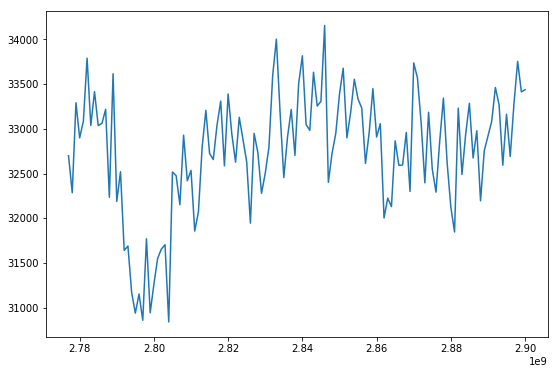

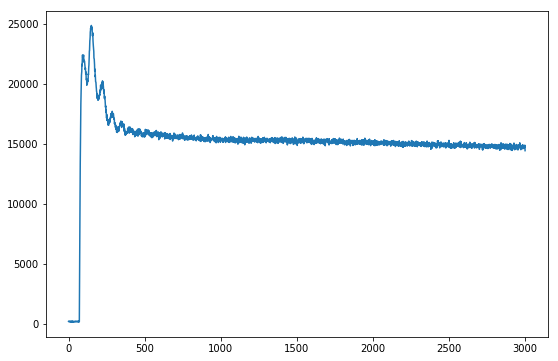

In [37]:
dat1 = np.sum(np.sum(save_array,axis=0)[:,70:70+261],axis=1)
#dat = np.sum(save_array[0][:,75:75+261],axis=1)
x = np.arange(start,stop+step,step)
plt.plot(x[:], dat1[:])
plt.show()
data1 = np.sum(save_array, axis=(0,1))
plt.plot(data)
plt.show()

start = 2777e6
stop = 2807e6
step = 0.2e6
power = -14
rep = int(1e5)
n_runs = 15
optimise_n = 5

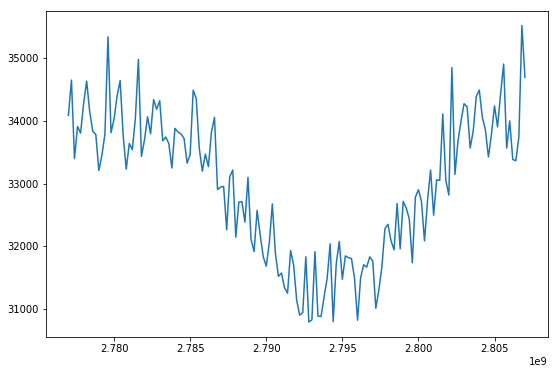

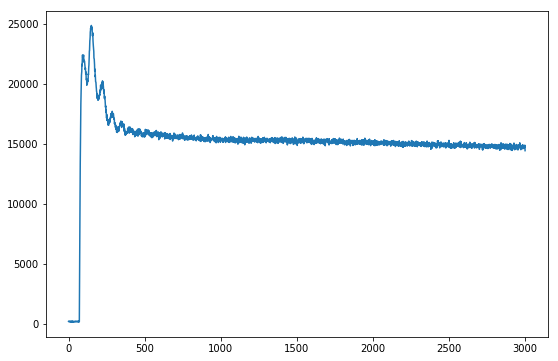

In [35]:
#dat = np.sum(np.sum(save_array,axis=0)[:,70:70+261],axis=1)
#dat = np.sum(save_array[0][:,75:75+261],axis=1)
x = np.arange(start,stop+step,step)
plt.plot(x[:], dat[:])
plt.show()
#data = np.sum(save_array, axis=(0,1))
plt.plot(data)
plt.show()

# CW ODMR

In [19]:
start = 2760e6
stop = 3010e6
step = 1e6
power = -17
rep = int(1e4)
n_runs = 60
arb_form_1, arb_form_2 = cw_odmr(20e6)
load_upload(arb_form_1, arb_form_2)
# err, save_array = cw_odmr_qudi(start, stop, step, power, rep, n_runs)
# odmrlogic.reset_sweep()
# pulsedmeasurementlogic.microwave_off()
# awg.set_output_off()

1010
Uploading with the GPIB . . .
Uploading arb_test_1.WFM to AWG (1 of 1)

Uploading with the GPIB . . .
Uploading arb_test_2.WFM to AWG (1 of 1)



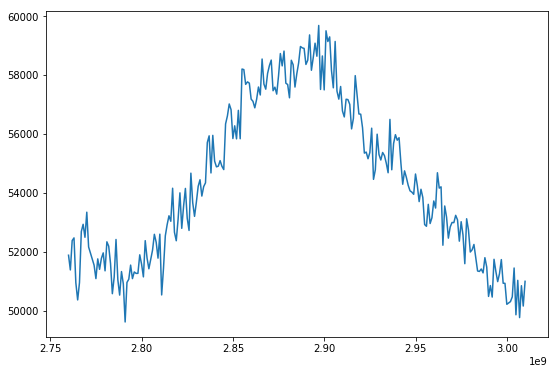

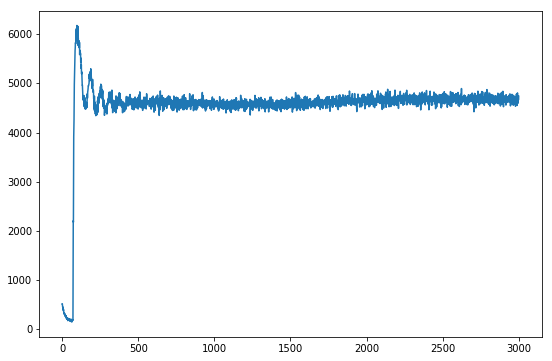

In [98]:
dat = np.sum(np.sum(save_array,axis=0)[:,:],axis=1)
x = np.arange(start,stop+step,step)
plt.plot(x[:], dat[:])
plt.show()
data = np.sum(np.sum(save_array, axis=0),0)
plt.plot(data)
plt.show()

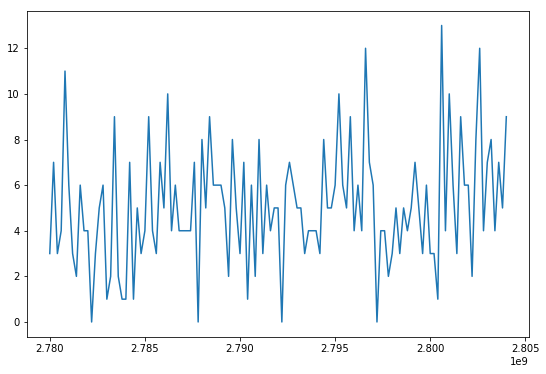

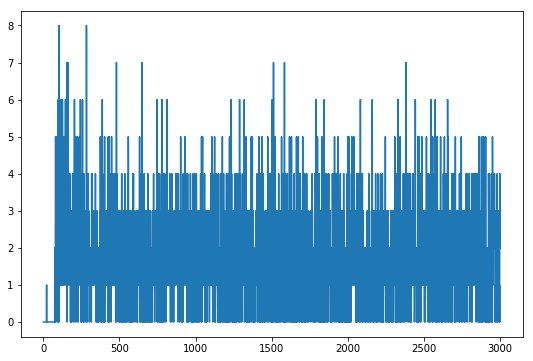

In [180]:
#save_array = fastcounter_timetagger.get_data_trace()
x = np.arange(start,stop+step,step)
data = np.sum(save_array[1][:,75:75+261], axis=1)
plt.plot(x[:], data[:])
plt.show()
# data = np.sum(save_array[0], axis=0)
# plt.plot(data)
# plt.show()

In [202]:
gimme

array([23., 36., 18., 22., 39., 42., 27., 21., 21., 23., 24., 16., 23.,
       22., 29., 28., 27., 25., 24., 17., 27., 22., 16., 28., 16., 22.,
       28., 29., 23., 32., 24., 30., 22., 25., 19., 26., 24., 10., 26.,
       14., 26., 15., 26., 24., 32., 18., 28., 25., 33., 29., 23., 32.,
       21., 23., 19., 20., 18., 21., 31., 22., 27., 18., 28., 26., 33.,
       23., 25., 16., 22., 26., 21., 33., 19., 33., 20., 18., 28., 21.,
       20., 27., 27., 22., 21., 34., 30., 36., 15., 16., 28., 18., 20.,
       22., 30., 23., 22., 20., 24., 16., 16., 31., 26., 26., 15., 37.,
       20., 30., 24., 27., 24., 24., 25., 25., 31., 30., 23., 24., 23.,
       22., 22., 24., 33.])

In [42]:
microwave_1._gpib_connection.query('SOUR:DM:IQ:STAT?')[0]

'1'

In [156]:
n=1
arb_form_1 = np.array(n*[0]+arb_form_1)
arb_form_2 = np.array(n*[0]+arb_form_2)
t = np.linspace(0, len(arb_form_1)-1, len(arb_form_1))

In [12]:
arb_form_3=np.array(arb_sin(len(t), 20e6, 0))
arb_form_4=np.array(arb_sin(len(t), 20e6, 90))
t = np.linspace(0, len(arb_form_1)-1, len(arb_form_1))

In [20]:
arb_form_1 = np.array(arb_zero(1000,1))#+arb_zero(9, 0.99)+arb_zero(10,0.99))
arb_form_2 = np.array(arb_zero(1000,0.5))#+arb_zero(9, 1)+arb_zero(10,1))
t = np.linspace(0, len(arb_form_1)-1, len(arb_form_1))

In [85]:
#arb_form = arb_xy8_single(100,20e6, 500000)
#t = np.linspace(0, len(arb_form)-1, len(arb_form))

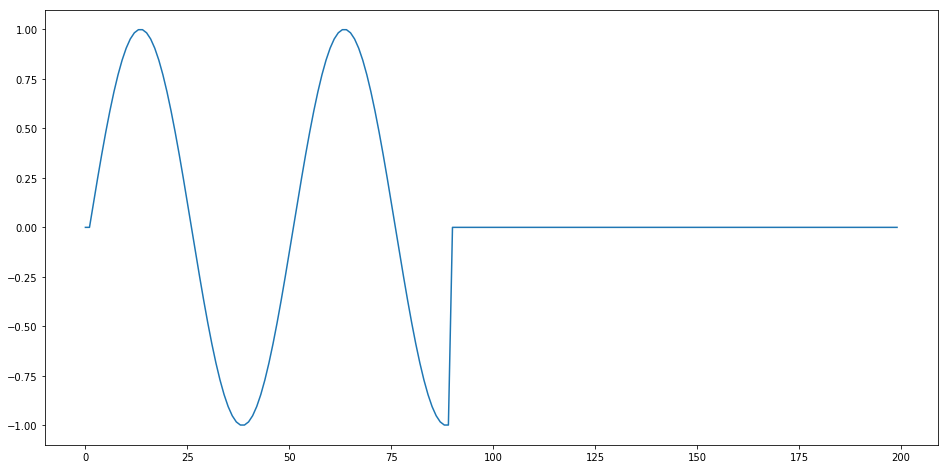

In [85]:
plt.figure(figsize=(16,8))
start = 0
stop = 451
plt.plot(arb_form_1[:200])
#plt.plot(t[start:stop],arb_form_2[start:stop])
#plt.plot(t[start:stop],arb_form_3[start:stop], 'o')
#plt.plot(t[start:stop],arb_form_4[start:stop])
#plt.plot(t,arb_form_2)
plt.show()

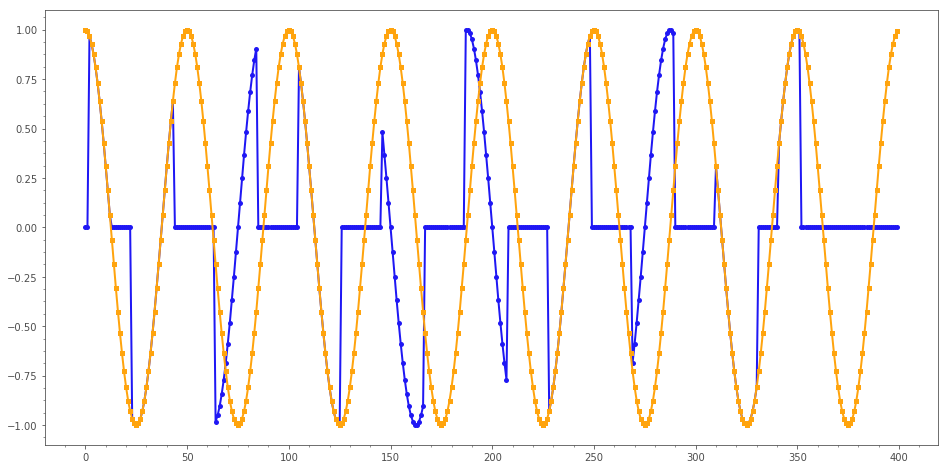

In [278]:
plt.figure(figsize=(16,8))
start = 0
stop = 400
#plt.plot(t[start:stop],arb_form_1[start:stop])
plt.plot(t[start:stop],arb_form_2[start:stop])
#plt.plot(t[start:stop],arb_form_3[start:stop])
plt.plot(t[start:stop],arb_form_4[start:stop])
#plt.plot(t,arb_form_2)
plt.show()

In [127]:
arb_1 = Arbitrary_waveform(duration = len(arb_form_1), waveform=arb_form_1)
wav_arb_1 = Waveform('arb_test_1', arb_1, offset=0, file_type='WFM', sampling = 1e9)

In [42]:
arb_1 = Arbitrary_waveform(duration = len(arb_form_1), waveform=arb_form_1)
wav_arb_1 = Waveform('arb_test_1', arb_1, offset=0, file_type='WFM', sampling = 1e9)

arb_2 = Arbitrary_waveform(duration = len(arb_form_2), waveform=arb_form_2)
wav_arb_2 = Waveform('arb_test_2', arb_2, offset=0, file_type='WFM', sampling = 1e9)

In [86]:
wav_arb_1.plot()

Traceback (most recent call last):
  File "C:\qudi\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-86-b913f610d603>", line 1, in <module>
    wav_arb_1.plot()
NameError: name 'wav_arb_1' is not defined


In [44]:
awg.upload(wav_arb_1)
files_dict = awg.list_files("")[2];
wav_arb_1.name in files_dict.keys()

awg.upload(wav_arb_2)
files_dict = awg.list_files("")[2];
wav_arb_2.name in files_dict.keys()

Uploading with the GPIB . . .
Uploading arb_test_1.WFM to AWG (1 of 1)

Uploading with the GPIB . . .
Uploading arb_test_2.WFM to AWG (1 of 1)



True

In [45]:
awg.load('arb_test_1.WFM', 1)
awg.load('arb_test_2.WFM', 2)

In [46]:
awg.set_mode('T')
awg.set_vpp(0.9)

In [47]:
awg.run()
awg.set_output_on()

In [1]:
awg.set_output_off()
awg.stop()

In [5]:
microwave_1._command_wait('OUTP:STAT OFF?')

In [24]:
microwave_1._command_wait('SOUR:DM:IQ:STAT ON')

In [18]:
microwave_1._command_wait('SOUR:FREQ:CW 0.5 GHz')

In [155]:
awg.gpib.close()

In [20]:
awg.set_mode('C')

In [48]:
microwave_2._gpib_connection.write('')
microwave_1._command_wait('')
microwave_1._gpib_connection.query('')

In [914]:
ramp = Ramp(duration=1000, start=-1, stop=1, marker1=False, marker2=False)
pulse_seq = [ramp]
wav_ramp = Waveform('ramp', pulse_seq, offset=1, file_type='WFM',
                 sampling=1e9)

In [913]:
# pulse = Pulse(duration=256)
sin = Sin(duration=5700, freq=0.00010)
pulse_seq = [sin]
wav_sin = Waveform('sinnetest4', pulse_seq, offset=0, file_type='WFM',
                 sampling=1e9)

In [606]:
device_created_file=awg.get_file_data("sinetest.wfm")[:-3]
FILENAME="sinereupload11.wfm"

HEADER=f'MMEM:DATA "{FILENAME}",'

DATAPRE = "MAGIC 1000\r\n#512800" #.encode("ascii")
DATA= device_created_file[len("#512843MAGIC 1000rn#512800"):-len("CLOCK 1.0000000000e+09")]
TRAILER = "CLOCK 1.0000000000e+09\r\n" #.encode("ascii")
print("Uploading file...")
COMMAND=DATA # DATAPRE+DATA+TRAILER

nBytes=len(DATAPRE.encode('ascii')+COMMAND+TRAILER.encode('ascii'))
nDigits=len(str(nBytes))

HEADER_TWO =f"#{nDigits}{nBytes}".encode("ascii")

#DATAPRE = fil.header
print(HEADER.encode("ascii")+HEADER_TWO+DATAPRE.encode("ascii")+COMMAND+TRAILER.encode("ascii"))
awg.tell_raw(HEADER.encode("ascii")+HEADER_TWO+DATAPRE.encode("ascii")+COMMAND+TRAILER.encode("ascii"))

print("Checking for file...")
try:
    uploaded_file=awg.get_file_data(FILENAME)
    print("File found.")
except:
    print("File not found")

Uploading file...
b'MMEM:DATA "sinereupload11.wfm",#512843MAGIC 1000\r\n#512800\x00\x00\x00\x00\x03\xd5\xe2\xcd;\x00\xcb\xe1M<\x00\x0bh\x9a<\x00\xa1\xdd\xcd<\x00\x91\xa8\x00=\x00\x05a\x1a=\x00\xea\x174=\x00\xfc\xccM=\x00\xfb\x7fg=\x00Q\x98\x80=\x00Xo\x8d=\x00\xf1D\x9a=\x00\xfb\x18\xa7=\x00T\xeb\xb3=\x00\xdc\xbb\xc0=\x00q\x8a\xcd=\x00\xf3V\xda=\x00@!\xe7=\x006\xe9\xf3=\x00[W\x00>\x00\xcf\xb8\x06>\x00\xe6\x18\r>\x00\x90w\x13>\x00\xbd\xd4\x19>\x00[0 >\x00[\x8a&>\x00\xad\xe2,>\x00?93>\x00\x01\x8e9>\x00\xe3\xe0?>\x00\xd51F>\x00\xc6\x80L>\x00\xa6\xcdR>\x00d\x18Y>\x00\xf1`_>\x00<\xa7e>\x005\xebk>\x00\xcb,r>\x00\xefkx>\x00\x90\xa8~>\x00Oq\x82>\x00\x05\x8d\x85>\x00a\xa7\x88>\x00[\xc0\x8b>\x00\xec\xd7\x8e>\x00\x0b\xee\x91>\x00\xb1\x02\x95>\x00\xd6\x15\x98>\x00p\'\x9b>\x00z7\x9e>\x00\xeaE\xa1>\x00\xb9R\xa4>\x00\xde]\xa7>\x00Sg\xaa>\x00\x0fo\xad>\x00\nu\xb0>\x00<y\xb3>\x00\x9e{\xb6>\x00(|\xb9>\x00\xd2z\xbc>\x00\x95w\xbf>\x00hr\xc2>\x00Dk\xc5>\x00!b\xc8>\x00\xf8V\xcb>\x00\xc1I\xce>\x00t:\xd1>\x00\t

Checking for file...
File found.
